# Práctica 3 - Ejercicio 2

Asignatura: Programación para la Inteligencia Artificial

Alumno:Jose Antonio Luque Luque

Uno de los primeros modelos propuestos para la generación de datos usando Aprendizaje profundo fue el *Variational Autoencoder* (VAE).

Un VAE es una red autocodificadora que durante su entrenamiento, en lugar de codificar a un espacio latente de manera determinista (cada ejemplo tiene asociada una codificación), asocia distribuciones gaussianas que se muestrean para obtener una codificación que seguidamente se decodifica. Por tanto, el proceso queda como sigue:

$$\mu, \sigma^2 = e_{\theta_1}(x)$$

$$z \sim \mathcal{N}(\mu, \sigma^2) $$

$$y = d_{\theta_{2}} (z)$$

Para realizar el entrenamiento como cualquier red autocodificadora, se incluye una función de pérdida de reconstrucción:

$$L_{r}(x,y)$$

Pero además se añade una función de pérdida con el objetivo de regularizar las distribuciones gaussianas que pueden aprenderse. Para esto se usa la Divergencia de Kullback-Leibler, que mide el grado de disimilitud entre una distribución de probabilidad $Q$ respecto a una distribución de probabilidad $P$:

$$D_{KL}(P,Q) = \sum_{x \in X} P(x) log (\frac{P(x)}{Q(x)})$$

La divergencia KL se utiliza para penalizar que las distribuciones gaussianas se alejen de la distribución gaussiana de media 0 y varianza 1 ($\mathcal{N}(0, 1)$). Teniendo eso en cuenta, su formulación se puede simplificar a:

$$L_{KL}(\mu, \sigma)= \sum_{i=0}^n -\frac{1}{2}(1+log (\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

Siendo la función de pérdida que se usa durante el entrenamiento:

$$L = L_{r} + \alpha L_{KL}$$

con $\alpha$ un hiperparámetro que controla cuánto peso tiene la divergencia de Kullback-Leibler respecto a la pérdida de reconstrucción.

Tras implementar el VAE, se pide entrenarlo para los datos de  Fashion-MNIST con un espacio latente de 8 dimensiones (el vector $\mu$ y el que representa sus respectivas varianzas tienen 8 dimensiones cada uno). Una vez entrenado y comprobado debidamente que funciona, se pide mostrar las componentes del vector $\mu$ del conjunto de test en el espacio latente usando gráficas bidimensionales que indican la clase de cada ejemplo como en el Ejercicio 1.

Después, se debe extraer el vector prototípico para cada clase en el conjunto de test (la media de los vectores $\mu$ para cada clase) y mostrar las imágenes generadas por el decodificador a partir de las codificaciones interpoladas entre los vectores prototípicos de dos clases cualesquiera. Lo de los vectores se hace con torch.lerp()

El cuaderno entregado debe llamarse ApellidosNombrePractica3Ejercicio2.ipynb

Notas:
 * Para realizar el muestreo $z$ permitiendo la retropropagación del error se usa el "truco de reparametrización": no muestrear directamente la distribución gaussiana obtenida (eso rompería el grafo de cómputo), sino la distribución gaussiana $\hat{z} \sim \mathcal{N}(0, 1)$ y aprovechar la propiedad de las gaussianas para convertir el muestreo de una distribución gaussiana en el de otra para que (una vez simplificado aprovechando que se muestrea la normal) quede  $z =  \hat{z} \sigma + \mu$.
 * Es más fácil (y equivalente) que el encoder genere el logaritmo de la varianza en lugar de la varianza. Así se evita la posibilidad de intentar computar un $log(0)$. Obviamente hay que ajustar las fórmulas que se implementan de manera acorde.
 * Aunque PyTorch implementa diversas funciones para calcular la divergencia KL, ninguna está directamente pensada para este uso y su aplicación no es directa, así que es más fácil simplemente implementarla. Hay que recordar usar los operadores de PyTorch para que se genere el grafo de cómputo sin problema y que la pérdida de un lote debe ser la media de las pérdidas de los ejemplos que lo forman.
 * El valor $\alpha$ para conseguir un entrenamiento apropiado puede ser muy bajo según el conjunto de datos al que se aplique (incluso menos de 0.01).

Device: cuda:0


epoch: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s, loss=0.0827]


Test loss (recon + alpha*KL): 0.083795


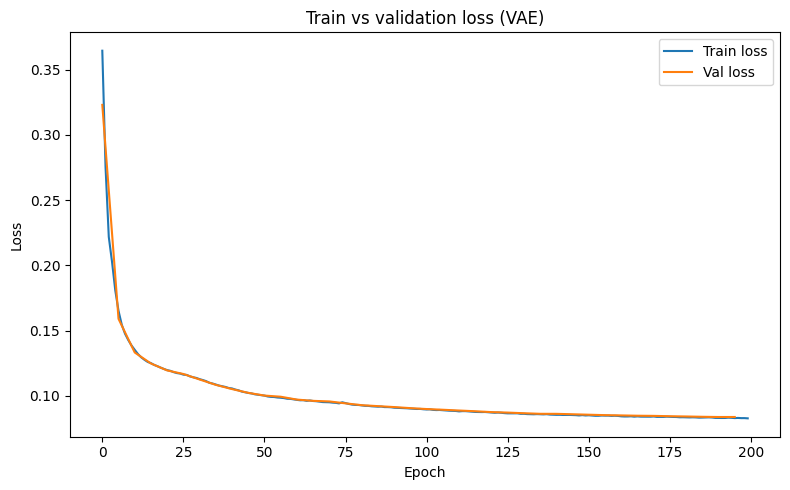

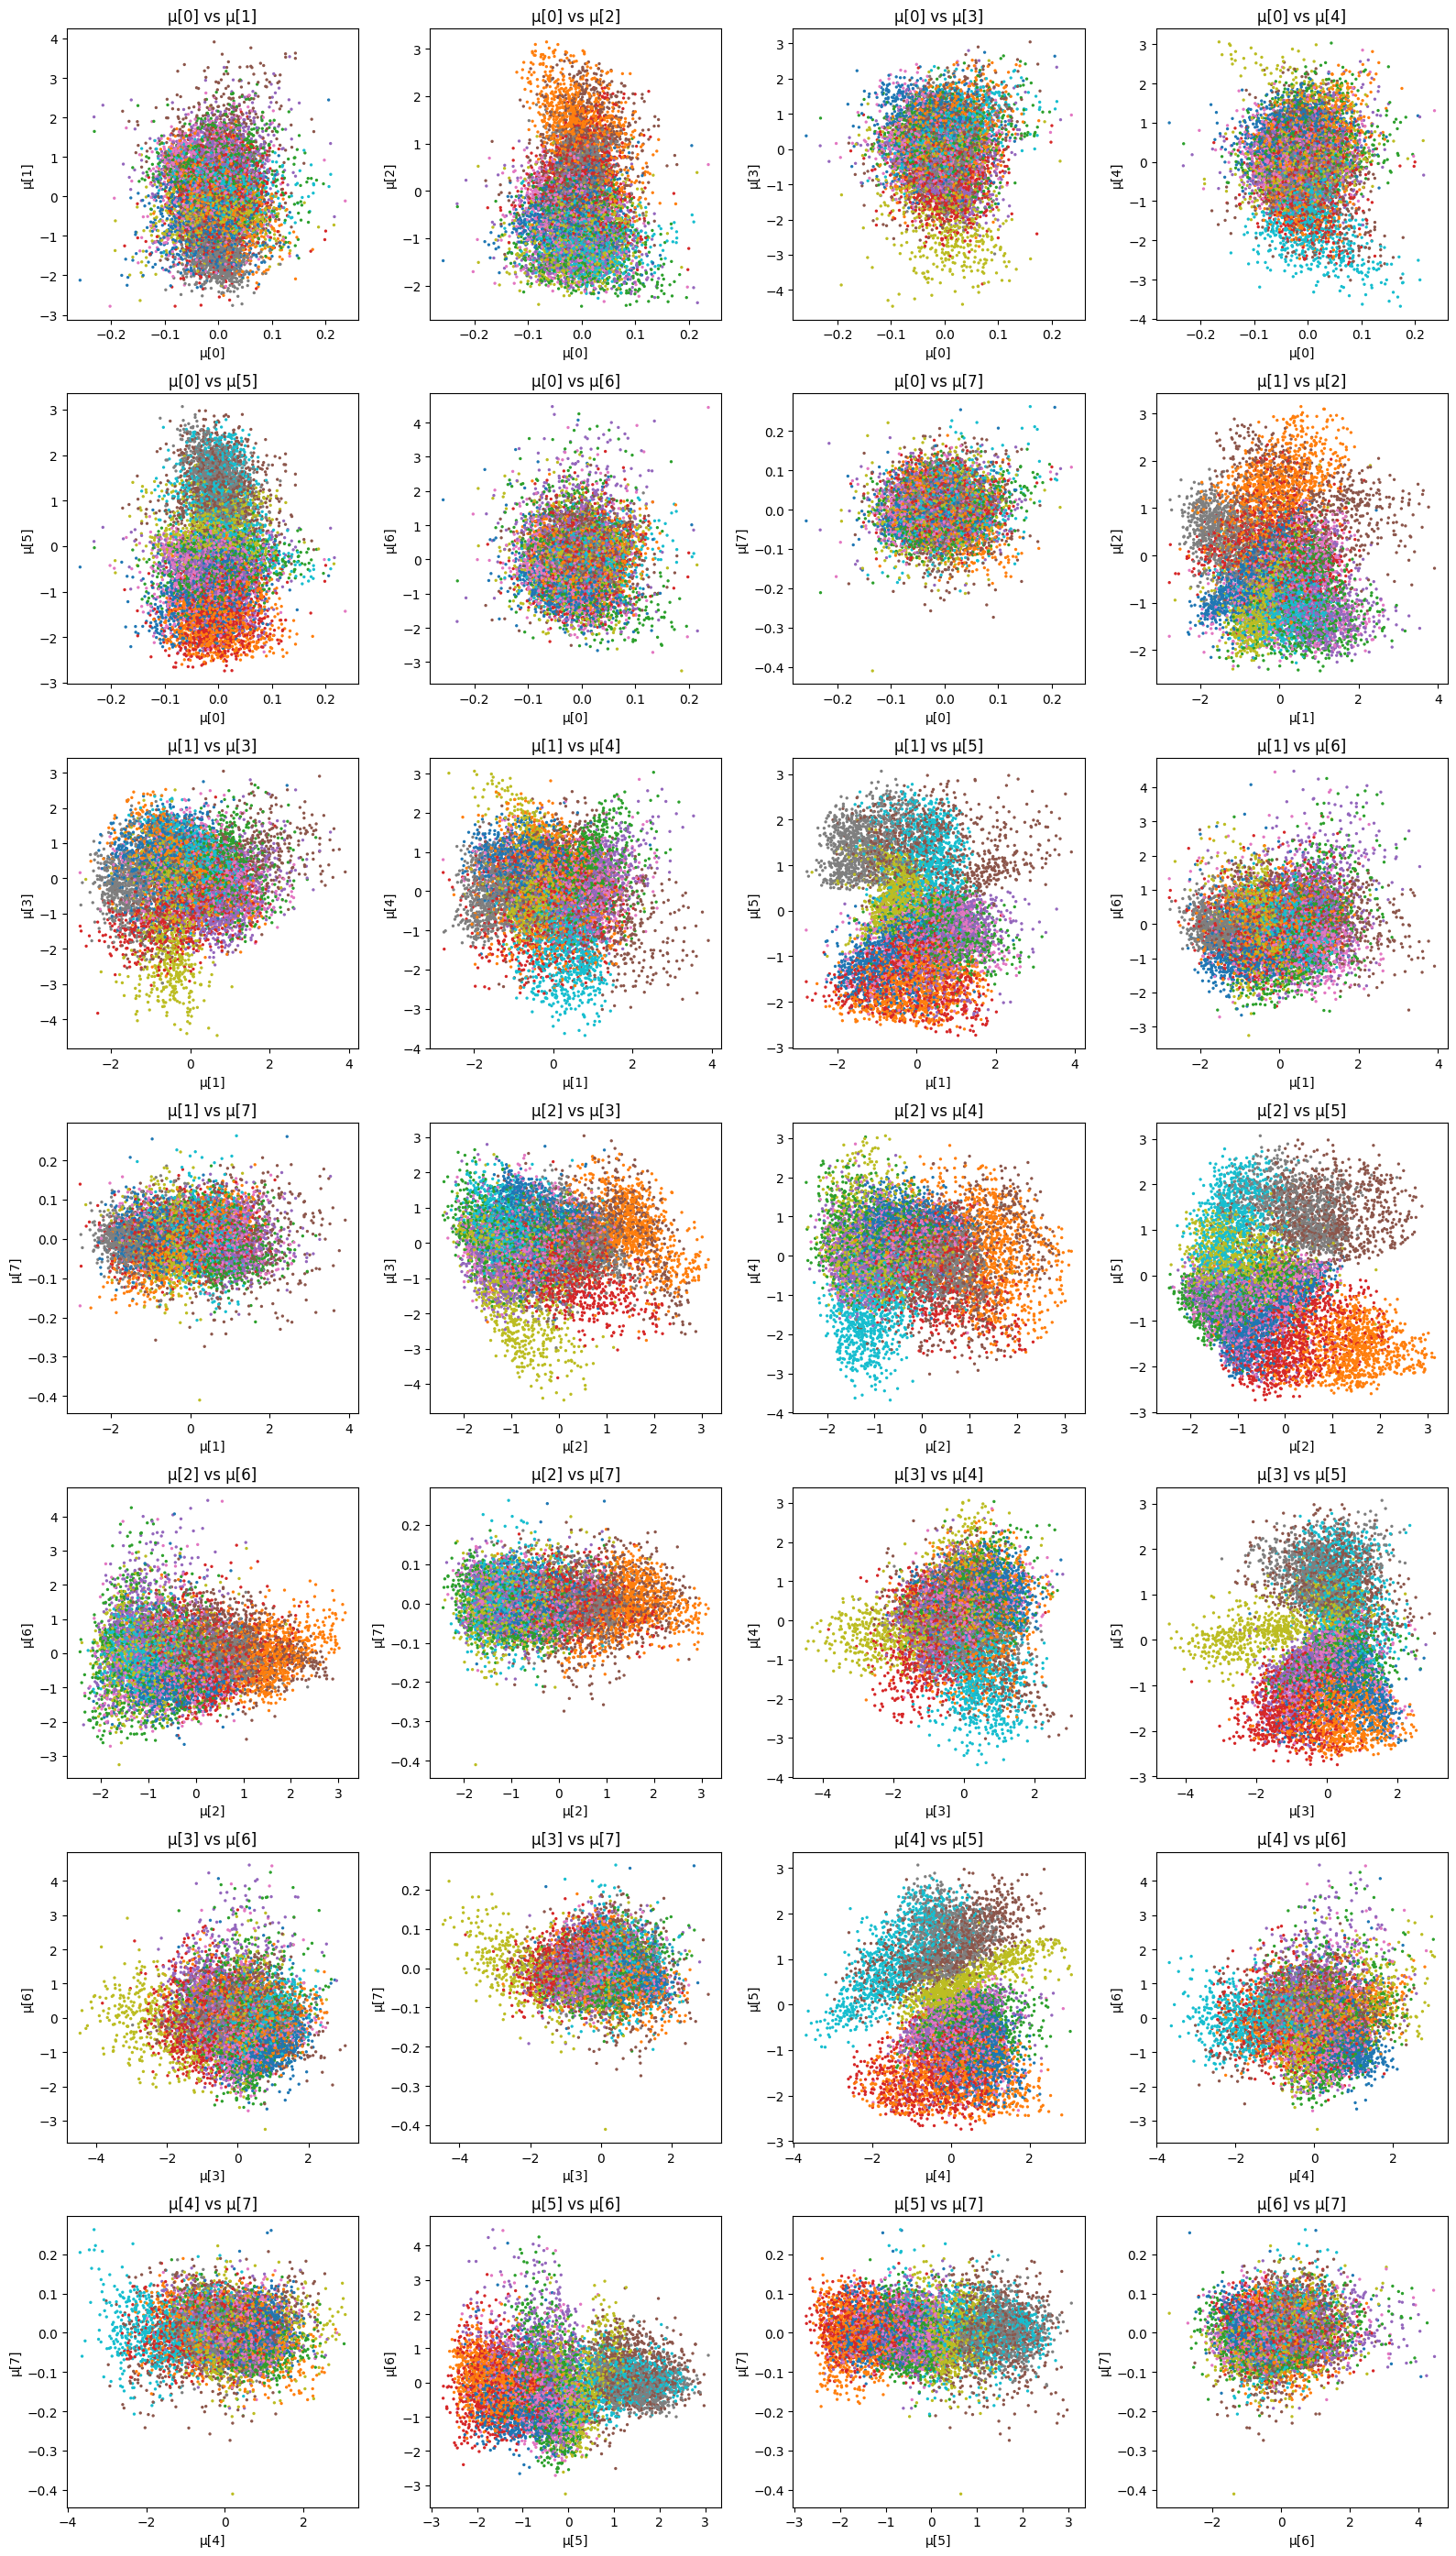

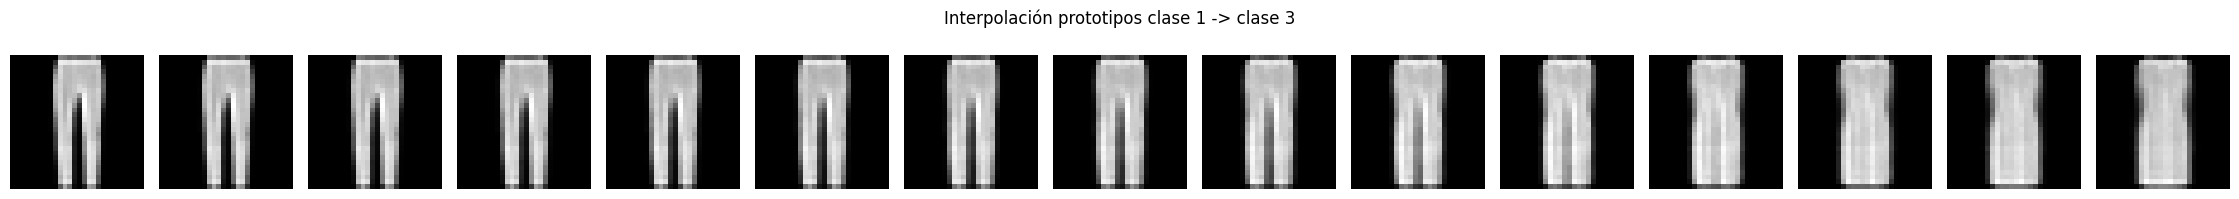

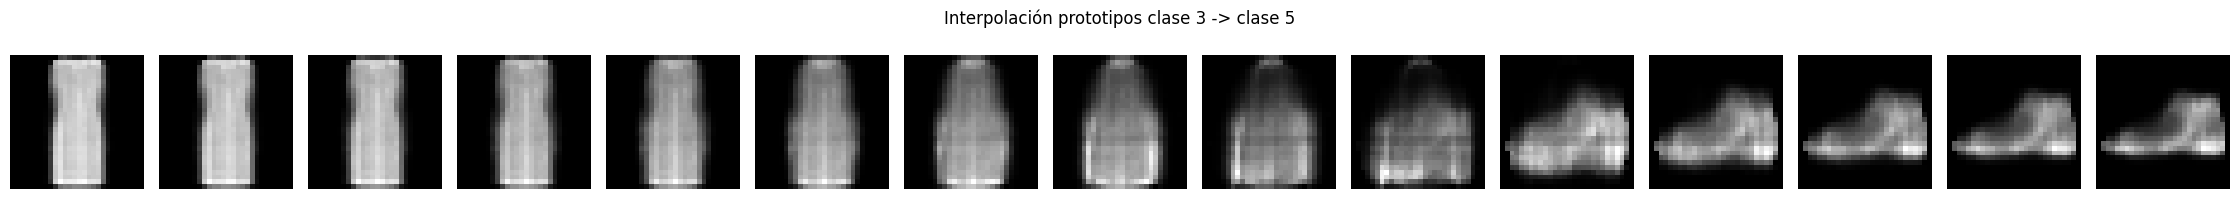

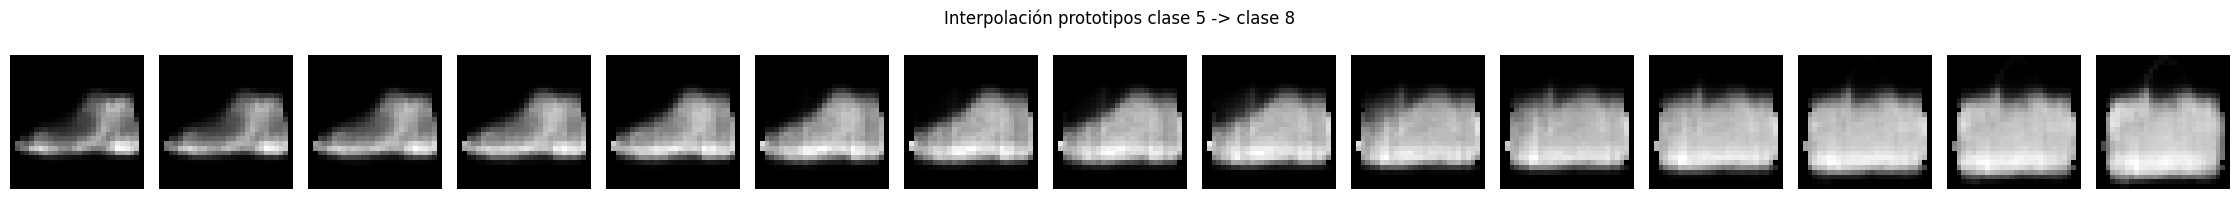

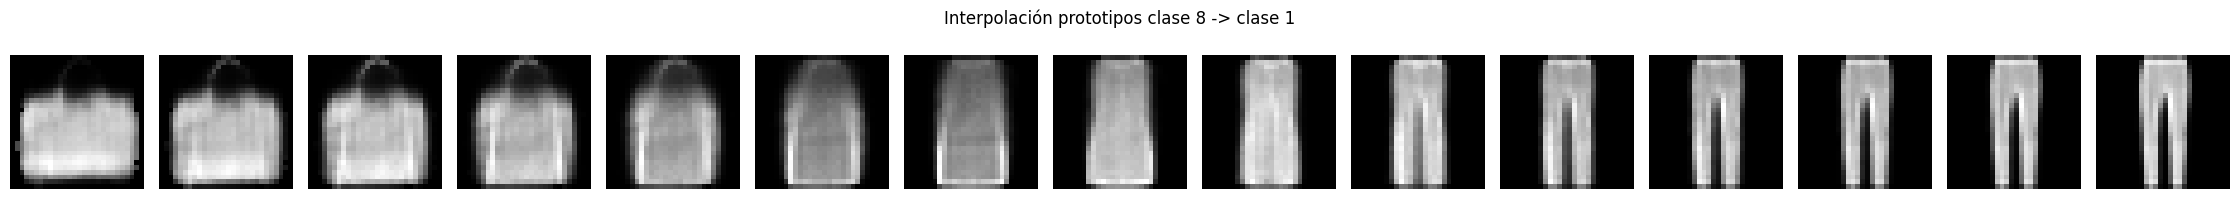

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

workpath = './data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class CudaDataset(Dataset):
    def __init__(self, dataset, device, transform=None):
        self.dataset = dataset
        self.device = device
        self.transform = transform

        self.cuda_x = []
        self.cuda_y = []
        for x, y in tqdm(self.dataset, desc="Moving to GPU"):
            self.cuda_x.append(x.to(self.device))
            self.cuda_y.append(torch.tensor(y, device=self.device))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.cuda_x[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, self.cuda_y[idx]


class Early_Stop():
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_val_loss = None
        self.no_val_improvement_times = 0
        self.stop = False

    def check_stop(self, val_loss):
        if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
            self.best_val_loss = val_loss
            self.no_val_improvement_times = 0
        else:
            self.no_val_improvement_times += 1
            self.stop = self.no_val_improvement_times >= self.patience


class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()

        # Encoder común
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU()
        )

        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # z = mu + sigma * epsilon; epsilon ~ N(0,1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        recon = self.decoder(z)
        recon = recon.view(-1, 1, 28, 28)
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar



def vae_loss(recon_x, x, mu, logvar, recon_loss_fn, alpha):
    # Pérdida de reconstrucción: L_r(x,y)
    recon_loss = recon_loss_fn(recon_x, x)   # media en el batch

    # KL (N(mu, sigma^2) || N(0,1))
    # KL = -1/2 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_per_sample = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp(),
        dim=1
    )
    kl_loss = kl_per_sample.mean()

    loss = recon_loss + alpha * kl_loss
    return loss, recon_loss, kl_loss


def learning_loop_vae_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    recon_loss_fn,
    optimizer_cls,
    learning_rate,
    alpha,
    validation_freq,
    early_stop
):
    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

    epoch_loss_list = []
    val_loss_list = []

    with tqdm(range(epochs), desc="epoch") as pbar:
        for epoch in pbar:

            steps_loss_list = []

            for x_batch, _ in train_dataloader:
                recon_batch, mu_batch, logvar_batch = model(x_batch)

                loss, recon_loss, kl_loss = vae_loss(
                    recon_batch,
                    x_batch,
                    mu_batch,
                    logvar_batch,
                    recon_loss_fn,
                    alpha
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                steps_loss_list.append(loss.detach())

            train_loss = torch.stack(steps_loss_list).mean()
            epoch_loss_list.append(train_loss)
            pbar.set_postfix(loss=f"{train_loss.item():.4f}")

            # Validación
            if epoch % validation_freq == 0:

                val_step_loss_list = []
                with torch.no_grad():
                    for x_val, _ in val_dataloader:
                        recon_val, mu_val, logvar_val = model(x_val)
                        loss_val, _, _ = vae_loss(
                            recon_val,
                            x_val,
                            mu_val,
                            logvar_val,
                            recon_loss_fn,
                            alpha
                        )
                        val_step_loss_list.append(loss_val.detach())

                val_loss = torch.stack(val_step_loss_list).mean()
                val_loss_list.append(val_loss)

                early_stop.check_stop(val_loss)
                if early_stop.stop:
                    break

    return model, epoch_loss_list, val_loss_list


data_size = [50000, 10000]

base_train_dataset = datasets.FashionMNIST(
    root=workpath,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

full_train_dataset = CudaDataset(base_train_dataset, device)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, data_size)

base_test_dataset = datasets.FashionMNIST(
    root=workpath,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = CudaDataset(base_test_dataset, device)

batch_size = 4096
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


learning_rate = 1e-3
epochs = 200
validation_freq = 5
delta = 1e-3
patience = 25
early_stop = Early_Stop(patience=patience, delta=delta)
optimizer_cls = torch.optim.Adam

# L_r: aquí L1 medio por píxel
recon_loss_fn = nn.L1Loss()

latent_dim = 8
alpha = 1e-3   # peso de la KL respecto a la reconstrucción

model = VAE(latent_dim=latent_dim).to(device)

model, train_loss_list, val_loss_list = learning_loop_vae_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    recon_loss_fn,
    optimizer_cls,
    learning_rate,
    alpha,
    validation_freq,
    early_stop
)

test_loss_sum = 0.0
n_batches = 0

with torch.no_grad():
    for x_batch, _ in test_dataloader:
        recon_batch, mu_batch, logvar_batch = model(x_batch)
        loss, _, _ = vae_loss(
            recon_batch,
            x_batch,
            mu_batch,
            logvar_batch,
            recon_loss_fn,
            alpha
        )
        test_loss_sum += loss.item()
        n_batches += 1

test_loss = test_loss_sum / n_batches
print(f"Test loss (recon + alpha*KL): {test_loss:.6f}")


train_loss_values = [l.item() for l in train_loss_list]
val_loss_values = [l.item() for l in val_loss_list]

plt.figure(figsize=(8, 5))
plt.plot(train_loss_values, label="Train loss")

val_x = list(range(0, len(train_loss_values), validation_freq))[:len(val_loss_values)]
plt.plot(val_x, val_loss_values, label="Val loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs validation loss (VAE)")
plt.tight_layout()
plt.show()


all_mu = []
all_y = []


with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        _, mu_batch, _ = model(x_batch)
        all_mu.append(mu_batch.cpu())
        all_y.append(y_batch.cpu())

all_mu = torch.cat(all_mu, dim=0)
all_y = torch.cat(all_y, dim=0)

all_mu_np = all_mu.numpy()
all_y_np = all_y.numpy()

pairs = [(i, j) for i in range(latent_dim) for j in range(i + 1, latent_dim)]
n_pairs = len(pairs)
cols = 4
rows = math.ceil(n_pairs / cols)

plt.figure(figsize=(4 * cols, 4 * rows))
for k, (a, b) in enumerate(pairs, 1):
    plt.subplot(rows, cols, k)
    plt.scatter(all_mu_np[:, a], all_mu_np[:, b], c=all_y_np, cmap='tab10', s=2)
    plt.xlabel(f"μ[{a}]")
    plt.ylabel(f"μ[{b}]")
    plt.title(f"μ[{a}] vs μ[{b}]")
plt.tight_layout()
plt.show()


num_classes = 10
prototypes = []

for c in range(num_classes):
    mask = (all_y == c)
    mu_c = all_mu[mask]
    proto_c = mu_c.mean(dim=0)
    prototypes.append(proto_c)

prototypes = torch.stack(prototypes, dim=0).to(device)   # shape (10, latent_dim)

def show_interpolation(class_a, class_b, steps=10):
    z_start = prototypes[class_a]
    z_end = prototypes[class_b]

    # Interpolación lineal en el espacio latente usando torch.lerp
    weights = torch.linspace(0.0, 1.0, steps, device=device)
    z_list = []
    for w in weights:
        z_interp = torch.lerp(z_start, z_end, w)
        z_list.append(z_interp)
    z_interp = torch.stack(z_list, dim=0)          # (steps, latent_dim)

    with torch.no_grad():
        recon_interp = model.decode(z_interp).cpu()

    plt.figure(figsize=(1.5 * steps, 2))
    for i in range(steps):
        img = recon_interp[i].squeeze().numpy()
        plt.subplot(1, steps, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Interpolación prototipos clase {class_a} -> clase {class_b}")
    plt.tight_layout()
    plt.show()

# Ejemplos de interpolación entre pares de clases
show_interpolation(1, 3, steps=15)
show_interpolation(3, 5, steps=15)
show_interpolation(5, 8, steps=15)
show_interpolation(8, 1, steps=15)
